In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [40]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)

cuda


In [71]:
t_steps = 200
num_demos = 100
dx, dy = 1, 1
x = torch.linspace(0, 1, t_steps).repeat(int(num_demos/2), 1)

noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0)
y0 = torch.unsqueeze(torch.sin(x*torch.pi) + noise, 2)

y1 = 1-y0

x = torch.unsqueeze(x.repeat(2,1), 2)
y = torch.cat((y0, y1), 0)
print(x.shape, y.shape)

torch.Size([100, 200, 1]) torch.Size([100, 200, 1])


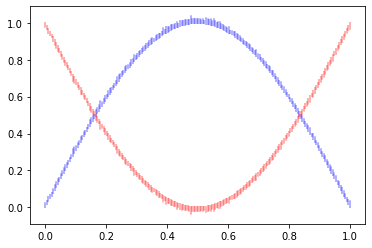

In [72]:
plt.plot(x[:50, :, 0], y[:50, :, 0], 'b', alpha=0.3)
plt.plot(x[51:, :, 0], y[51:, :, 0], 'r', alpha=0.3)
plt.show()

In [64]:
n_max = 6

def sample_training_demonstration():    
    rand_traj_ind = np.random.randint(0, num_demos)
    n = np.random.randint(1, n_max+1)

    rand_traj = y[rand_traj_ind, :, :]

    observation_indices = np.random.choice(np.arange(t_steps), n+1, replace=False) # n+1: +1 is for sampling the target
    
    observations = torch.cat((rand_traj[observation_indices[:-1], :], 
                              x[rand_traj_ind, observation_indices[:-1], :]), 1)
    targetX = torch.Tensor(x[rand_traj_ind, observation_indices[-1], :])
    targetY = torch.Tensor(rand_traj[observation_indices[-1], :])
    
    if device.type == 'cuda':
        return observations.float().cuda(), targetX.float().cuda(), targetY.float().cuda()
    else:
        return observations.float(), targetX.float(), targetY.float()
    
    
aadsada = sample_training_demonstration()

In [67]:
class BCNP(nn.Module):
    def __init__(self, in_shape):
        super(BCNP, self).__init__()
        
        dx, dy = in_shape[0], in_shape[1]
        
        dz = 128
        dzt = dz+dx
        
        self.encoder = nn.Sequential(
            nn.Linear(dx+dy, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dz)
        )
        
        self.f0 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

        self.f1 = nn.Sequential(
            nn.Linear(dzt, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dy*2)
        )

#         self.f2 = nn.Sequential(
#             nn.Linear(dzt, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, dy*2)
#         )
        
#         self.lin0 = nn.Linear(dz+dy*2, dy)
#         self.lin1 = nn.Linear(dz+dy*2, dy)
#         self.lin2 = nn.Linear(dz+dy*2, dy)

    def forward(self, observations, target):
        z_out = self.encoder(observations)
        z = torch.mean(z_out, dim=0)
        
        zs = z.repeat(target.shape[0], 1).to(device)  # repeating the same z for each target
        print("tes")
        print(z.shape)
        print(zs.shape)
        z_target = torch.cat((zs, target), 1)
        
        print(z_target.shape)
        
        m0, sig0 = self.f0(z_target)
        m1, sig1 = self.f1(z_target)
        m2, sig2 = self.f2(z_target)
        
#         fzs = z.repeat(3, 1).to(device)  # 3 decoders (f)
        
        out0 = self.lin0(torch.cat((z, m0, sig0), 1))
        out1 = self.lin1(torch.cat((z, m1, sig1), 1))
        out2 = self.lin2(torch.cat((z, m2, sig2), 1))
        
        return out0, out1, out2
        
#         sig0, sig1, sig2 = F.softplus(sig0), F.softplus(sig1), F.softplus(sig2)
#         dist0 = D.Independent(D.Normal(loc=m0, scale=sig0), 1)
#         dist1 = D.Independent(D.Normal(loc=m1, scale=sig1), 1)
#         dist2 = D.Independent(D.Normal(loc=m2, scale=sig2), 1)
        
#         p0, p1, p2 = torch.mean(dist0.log_prob(target)), torch.mean(dist1.log_prob(target)), torch.mean(dist2.log_prob(target))

In [68]:
model = BCNP((1, 1))
model.to(device)

optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999), amsgrad=True)

val_after_epoch = 2500
epoch = 1

losses = np.zeros(int(epoch/val_after_epoch))
min_loss = 1e6
mse = nn.MSELoss()

for i in range(epoch):
    obss, tx, ty = sample_training_demonstration()
    
    optimizer.zero_grad()
    ty_preds = model(obss, tx)
    loss0 = mse(ty, ty_pred[0].detach())
    loss1 = mse(ty, ty_pred[1].detach())
    loss2 = mse(ty, ty_pred[2].detach())
    
    print(loss0, loss1, loss2)
    
    loss.backward()
    optimizer.step()
    
    print(i, end="\r")
    if i%val_after_epoch == 0:
        val_loss = validate()
        print(f"{i}: {val_loss}")
    
        if val_loss < min_loss:
            min_loss = val_loss
            torch.save(model.state_dict(), f'{path}../../best_model.pt')

torch.Size([128])
torch.Size([1, 128])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1